In [ ]:
# Cell 1: Install and import required libraries
!pip install -q xgboost

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)


In [ ]:
# Cell 2: Mount Google Drive (optional)
# If you want to save or load files from Drive
from google.colab import drive
# drive.mount('/content/drive')  # Uncomment if you wish to use Google Drive


In [ ]:
# Cell 3: Load your dataset
from google.colab import files

local_path = '/content/CO2 Emissions_Canada.csv'

if not os.path.exists(local_path):
    print("Upload your CSV file")
    uploaded = files.upload()
    uploaded_fname = list(uploaded.keys())[0]
    local_path = os.path.join('/content', uploaded_fname)

df = pd.read_csv(local_path)
print("Data loaded successfully. Shape:", df.shape)
df.head()


Data loaded successfully. Shape: (7385, 12)


,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [ ]:
# Cell 4: Check info, missing values, and summary
df.info()
print("\nMissing values:\n", df.isnull().sum())
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Make,7385,42,FORD,628,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,7385,2053,F-150 FFV,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Class,7385,16,SUV - SMALL,1217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine Size(L),7385.0,NaN,NaN,NaN,3.160068,1.35417,0.9,2.0,3.0,3.7,8.4
Cylinders,7385.0,NaN,NaN,NaN,5.61503,1.828307,3.0,4.0,6.0,6.0,16.0
Transmission,7385,27,AS6,1324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fuel Type,7385,5,X,3637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fuel Consumption City (L/100 km),7385.0,NaN,NaN,NaN,12.556534,3.500274,4.2,10.1,12.1,14.6,30.6
Fuel Consumption Hwy (L/100 km),7385.0,NaN,NaN,NaN,9.041706,2.224456,4.0,7.5,8.7,10.2,20.6
Fuel Consumption Comb (L/100 km),7385.0,NaN,NaN,NaN,10.975071,2.892506,4.1,8.9,10.6,12.6,26.1


In [ ]:
# Cell 5: Clean column names and identify target
df.columns = df.columns.str.strip()
possible_targets = [c for c in df.columns if 'co2' in c.lower() or 'emission' in c.lower()]
print("Possible target columns:", possible_targets)

target_col = None
if 'CO2 Emissions(g/km)' in df.columns:
    target_col = 'CO2 Emissions(g/km)'
elif possible_targets:
    target_col = possible_targets[0]
else:
    raise ValueError("No CO2 target column found. Check column names!")

print("Using target column:", target_col)


Possible target columns: ['CO2 Emissions(g/km)']
Using target column: CO2 Emissions(g/km)


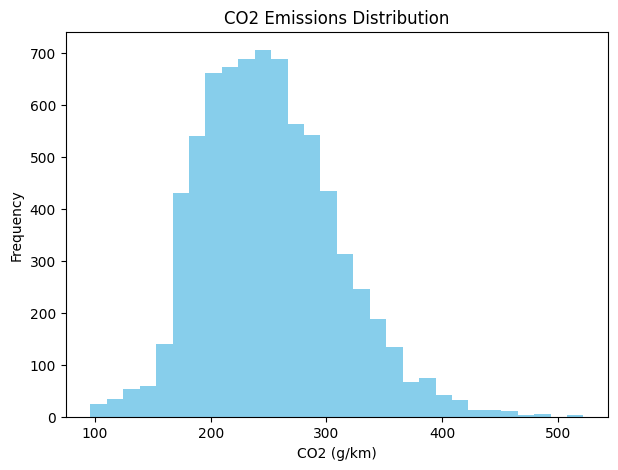

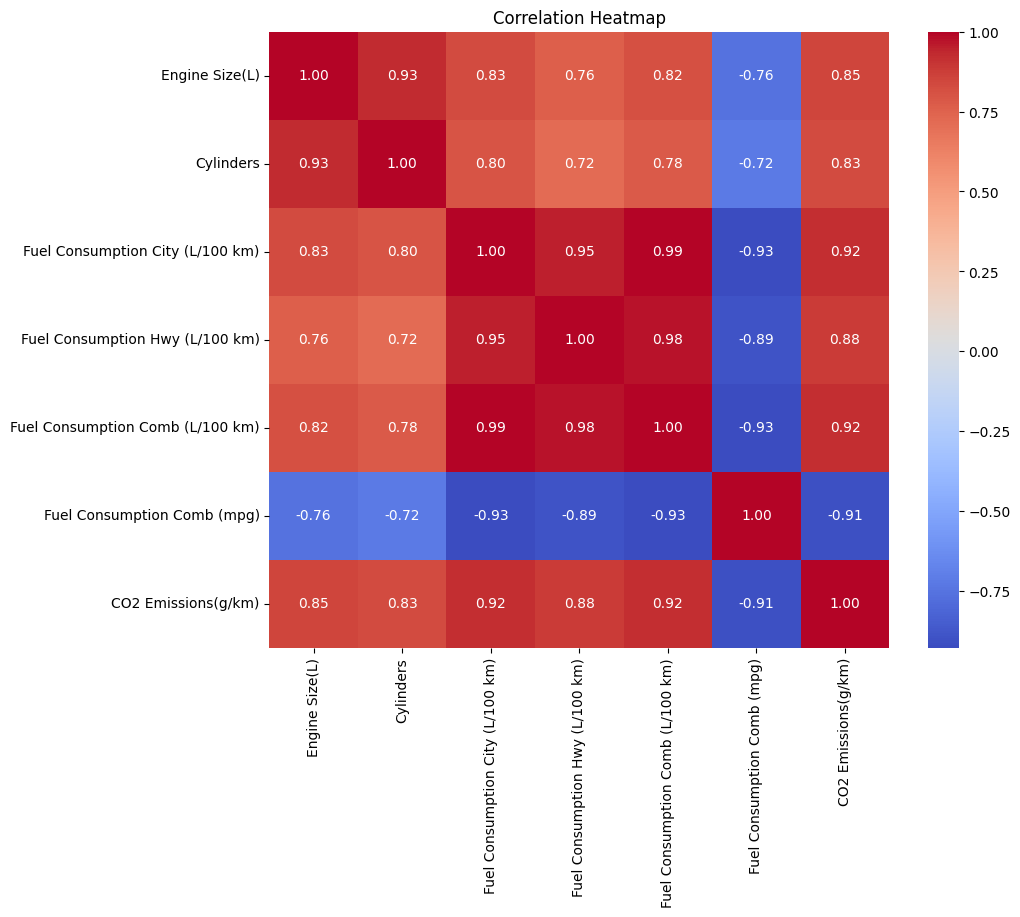

In [ ]:
# Cell 6: Exploratory Data Analysis (EDA)

# Target distribution
plt.figure(figsize=(7,5))
plt.hist(df[target_col], bins=30, color='skyblue')
plt.title('CO2 Emissions Distribution')
plt.xlabel('CO2 (g/km)')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap for numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


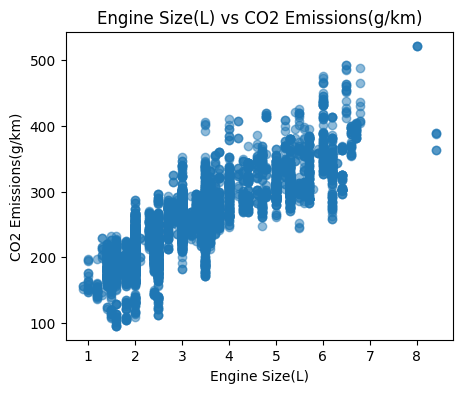

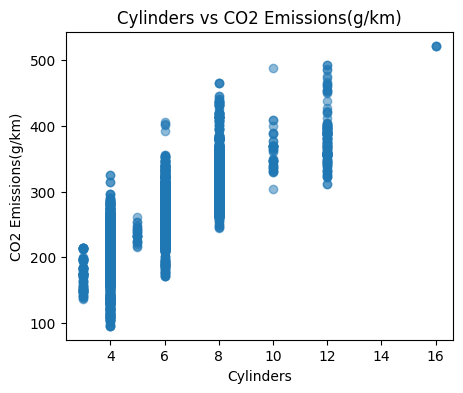

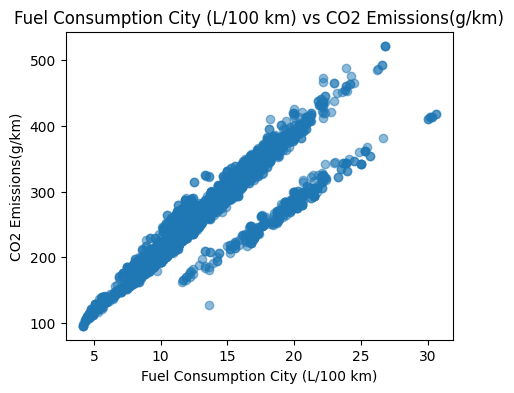

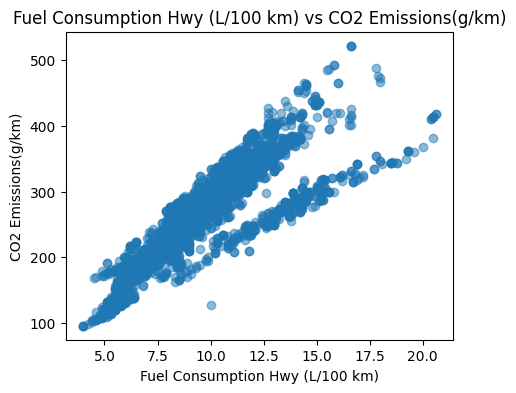

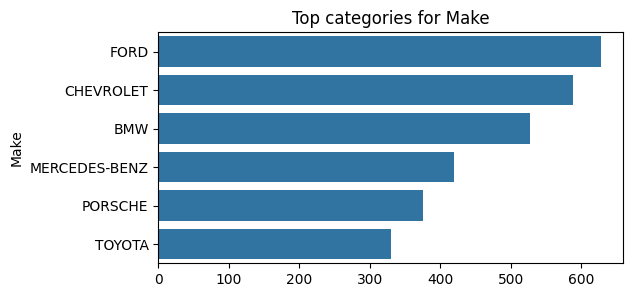

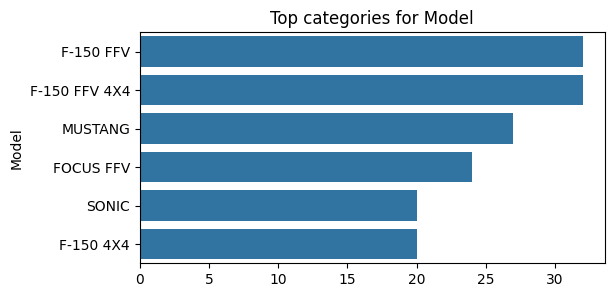

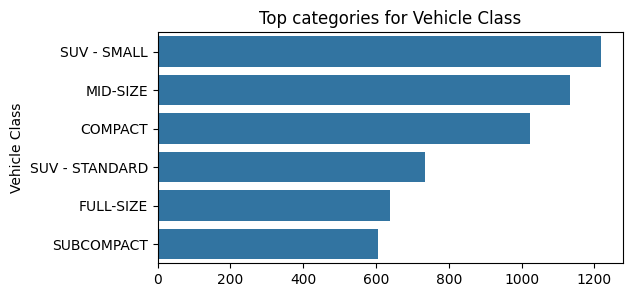

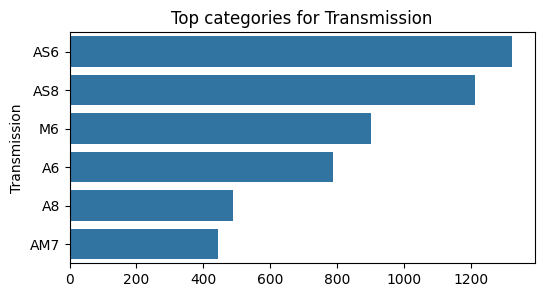

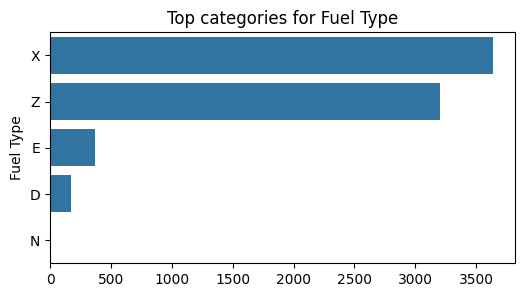

In [ ]:
# Cell 7: Scatter and bar plots
numeric_cols = [c for c in df.select_dtypes(include=np.number).columns if c != target_col]
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Scatter plots for first few numeric variables
for col in numeric_cols[:4]:
    plt.figure(figsize=(5,4))
    plt.scatter(df[col], df[target_col], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.title(f'{col} vs {target_col}')
    plt.show()

# Top categories of each categorical column
for col in cat_cols:
    top = df[col].value_counts().nlargest(6)
    plt.figure(figsize=(6,3))
    sns.barplot(x=top.values, y=top.index)
    plt.title(f'Top categories for {col}')
    plt.show()


In [ ]:
# Cell 8: Select useful features automatically
possible_features = ['Engine Size(L)', 'Cylinders', 'Transmission', 'Fuel Type',
                     'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption City (L/100 km)',
                     'Fuel Consumption Hwy (L/100 km)', 'Make', 'Year']

feature_cols = [c for c in df.columns if c in possible_features]
print("Selected features:", feature_cols)

X = df[feature_cols]
y = df[target_col]


Selected features: ['Make', 'Engine Size(L)', 'Cylinders', 'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)']


In [ ]:
# Cell 9: Preprocessing pipeline
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [ ]:
# Cell 10: Split dataset and train models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'LinearRegression': Pipeline([('pre', preprocessor), ('model', LinearRegression())]),
    'Ridge': Pipeline([('pre', preprocessor), ('model', Ridge())]),
    'RandomForest': Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(n_estimators=200, random_state=42))])
}

from xgboost import XGBRegressor
models['XGBoost'] = Pipeline([('pre', preprocessor), ('model', XGBRegressor(n_estimators=200, random_state=42, verbosity=0))])

results = {}
for name, pipe in models.items():
    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {'rmse': rmse, 'r2': r2, 'preds': preds}
    print(f"{name} → RMSE: {rmse:.3f}, R²: {r2:.3f}")


Training LinearRegression...
LinearRegression → RMSE: 29.704, R²: 0.991

Training Ridge...
Ridge → RMSE: 29.616, R²: 0.991

Training RandomForest...
RandomForest → RMSE: 11.083, R²: 0.997

Training XGBoost...
XGBoost → RMSE: 11.409, R²: 0.997


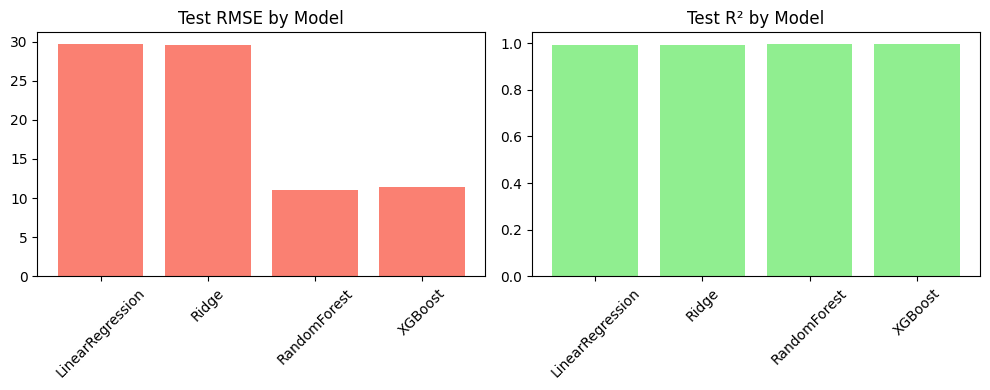

In [ ]:
# Cell 11: Compare models visually
names = list(results.keys())
rmses = [results[n]['rmse'] for n in names]
r2s = [results[n]['r2'] for n in names]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(names, rmses, color='salmon')
plt.title('Test RMSE by Model')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(names, r2s, color='lightgreen')
plt.title('Test R² by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


✅ Best model: RandomForest


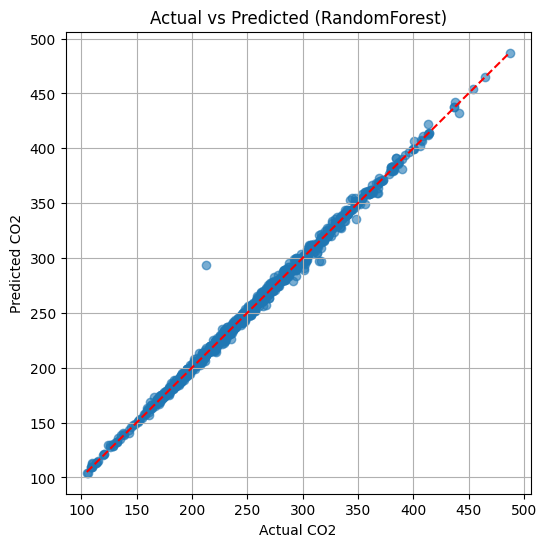

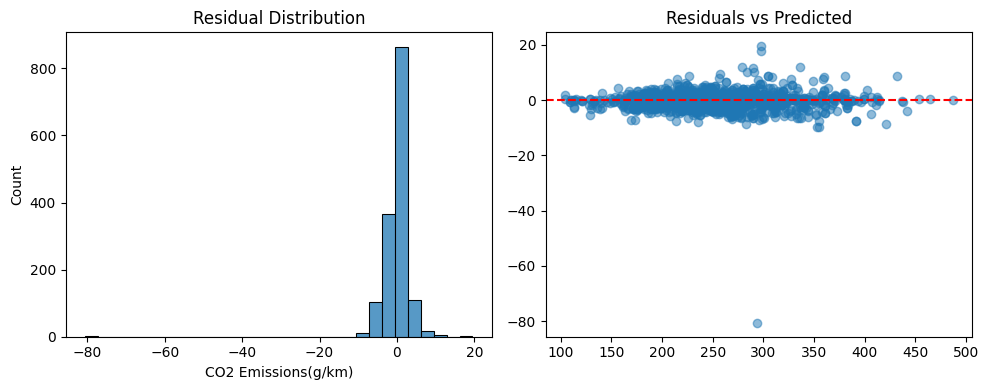

In [ ]:
# Cell 12: Evaluate best model and residuals
best_name = min(results, key=lambda k: results[k]['rmse'])
print(f"✅ Best model: {best_name}")
best_preds = results[best_name]['preds']

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual CO2')
plt.ylabel('Predicted CO2')
plt.title(f'Actual vs Predicted ({best_name})')
plt.grid(True)
plt.show()

residuals = y_test - best_preds
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(residuals, bins=30)
plt.title('Residual Distribution')

plt.subplot(1,2,2)
plt.scatter(best_preds, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()


In [ ]:
# Cell 13: Save best model pipeline
best_pipe = models[best_name]
joblib.dump(best_pipe, 'best_model_pipeline.joblib')
print("Model saved as 'best_model_pipeline.joblib'")

# Example: how to load and predict
"""
from joblib import load
pipe = load('best_model_pipeline.joblib')
sample = pd.DataFrame([{
    'Engine Size(L)': 2.0,
    'Cylinders': 4,
    'Fuel Type': 'X',
    'Transmission': 'A',
    'Fuel Consumption Comb (L/100 km)': 8.5
}])
print('Predicted CO2:', pipe.predict(sample)[0])
"""


Model saved as 'best_model_pipeline.joblib'


"\nfrom joblib import load\npipe = load('best_model_pipeline.joblib')\nsample = pd.DataFrame([{\n    'Engine Size(L)': 2.0,\n    'Cylinders': 4,\n    'Fuel Type': 'X',\n    'Transmission': 'A',\n    'Fuel Consumption Comb (L/100 km)': 8.5\n}])\nprint('Predicted CO2:', pipe.predict(sample)[0])\n"